MODNet is a light-weight **matting** objective decomposition network (MODNet), which can process portrait matting from a single input image in **real time**. The trimap-free model can run at **60 fps** on a GPU and achieves remarkable results in daily **photos and videos**. In this demo we will use the official pretrained **models** and convert them to **onnx and coreml** formats.



Install **pytorch** v1.6.0

In [ ]:
!pip install torch==1.6.0+cu101 torchvision==0.7.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
ERROR: Could not find a version that satisfies the requirement torch==1.6.0+cu101 (from versions: 1.11.0, 1.11.0+cpu, 1.11.0+cu102, 1.11.0+cu113, 1.11.0+cu115, 1.11.0+rocm4.3.1, 1.11.0+rocm4.5.2, 1.12.0, 1.12.0+cpu, 1.12.0+cu102, 1.12.0+cu113, 1.12.0+cu116, 1.12.0+rocm5.0, 1.12.0+rocm5.1.1, 1.12.1, 1.12.1+cpu, 1.12.1+cu102, 1.12.1+cu113, 1.12.1+cu116, 1.12.1+rocm5.0, 1.12.1+rocm5.1.1, 1.13.0, 1.13.0+cpu, 1.13.0+cu116, 1.13.0+cu117, 1.13.0+cu117.with.pypi.cudnn, 1.13.0+rocm5.1.1, 1.13.0+rocm5.2, 1.13.1, 1.13.1+cpu, 1.13.1+cu116, 1.13.1+cu117, 1.13.1+cu117.with.pypi.cudnn, 1.13.1+rocm5.1.1, 1.13.1+rocm5.2, 2.0.0, 2.0.0+cpu, 2.0.0+cpu.cxx11.abi, 2.0.0+cu117, 2.0.0+cu117.with.pypi.cudnn, 2.0.0+cu118, 2.0.0+rocm5.3, 2.0.0+rocm5.4.2, 2.0.1, 2.0.1+cpu, 2.0.1+cpu.cxx11.abi, 2.0.1+cu117, 2.0.1+cu117.with.pypi.cudnn, 2.0.1+cu118, 2.0.1+rocm5.3, 2.0.1+rocm5.4.2)
ERROR: No matching distribution found for torch==1.6.0+cu101


Clone the **MODNet** repository and download the pretrained checkpoints, along with samples.

In [ ]:
import os

# Download sample videos and images
!wget https://www.dropbox.com/s/1nck2tvmbjtlt28/data_modnet.zip
!unzip data_modnet.zip

# clone the MODNet github repository
%cd /content
if not os.path.exists('MODNet'):
  !git clone https://github.com/ZHKKKe/MODNet
%cd MODNet/

# Download the pre-trained ckpt for video and image matting
pretrained_ckpt = 'pretrained/modnet_webcam_portrait_matting.ckpt'
if not os.path.exists(pretrained_ckpt):
  !gdown --id 1Nf1ZxeJZJL8Qx9KadcYYyEmmlKhTADxX \
          -O pretrained/modnet_webcam_portrait_matting.ckpt
  !gdown --id 1mcr7ALciuAsHCpLnrtG_eop5-EYhbCmz \
          -O pretrained/modnet_photographic_portrait_matting.ckpt

--2023-07-17 00:10:35--  https://www.dropbox.com/s/1nck2tvmbjtlt28/data_modnet.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/1nck2tvmbjtlt28/data_modnet.zip [following]
--2023-07-17 00:10:35--  https://www.dropbox.com/s/raw/1nck2tvmbjtlt28/data_modnet.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc8715e0259ba113d53d9a30c219.dl.dropboxusercontent.com/cd/0/inline/B_-3TrKRHHaj_ez_c4bI6HuP8E0zttVZgaNzqoIqP3hY1haK2Tysalj9geHSuNIYWm29Moq_0bB0HPIXaKXkOj4iykRc2PTbWJEsIlV3qxUno9ge8vt2p4CvXM4LQ22mlotF1ijfZjpi9lYHUk_xyIH-CwfHIcQv-pOJxWwQdHvPiw/file# [following]
--2023-07-17 00:10:35--  https://uc8715e0259ba113d53d9a30c219.dl.dropboxusercontent.com/cd/0/inline/B_-3TrKRHHaj_ez_c4bI6HuP8E0zttVZgaNzqoIqP3hY1haK2Tysalj9geHSuNIYWm29Moq

To convert the original **pretrained** model to onnx format, **modify** the original network as follows:-

* In the modnet architecture set the argument **inference=True** as default value, in forward functions of LR, HR and MODNet modules.

* In the MODNet module, return only the **pred_matte** in the forward function and remove other tensors(outputs).

Choose the pytorch model for **portrait image matting**.

In [ ]:
%cd /content/MODNet/
pretrained_ckpt = 'pretrained/modnet_photographic_portrait_matting.ckpt'

/content/MODNet


Convert the pytorch model to **onnx** format.

In [ ]:
import io
import PIL
import numpy as np

import torch
import torch.nn as nn
import torchvision.transforms as transforms

from src.models.modnet import MODNet

model = MODNet(backbone_pretrained=False)
model = nn.DataParallel(model).cuda()

state_dict = torch.load(pretrained_ckpt)
model.load_state_dict(state_dict)
model.eval()

dummy_input = torch.randn(1, 3, 512, 512).cuda()
torch.onnx.export(model.module, dummy_input, '/content/modnet_image.onnx', export_params = True, opset_version=12, do_constant_folding=True, verbose=True, keep_initializers_as_inputs=True)

Install **onnx-simplifier** and optimize the onnx model.

In [ ]:
!pip install onnx-simplifier
!python3 -m onnxsim /content/modnet_image.onnx /content/modnet_image_optim.onnx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 40.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 101.9 MB/s eta 0:00:00
Traceback (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 187, in _run_module_as_main
    mod_name, mod_spec, code = _get_module_details(mod_name, _Error)
  File "/usr/lib/python3.10/runpy.py", line 146, in _get_module_details
    return _get_module_details(pkg_main_name, error)
  File "/usr/lib/python3.10/runpy.py", line 110, in _get_module_details
    __import__(pkg_name)
  File "/usr/local/lib/python3.10/dist-packages/onnxsim/__init__.py", line 1, in <module>
    from onnxsim.onnx_simplifier import simplify, main
  File "/usr/local/lib/python3.10/dist-packages/onnxsim/onnx_simplifier.py", line 14, in <module>
    import onnx.checker  # type: ignore
ModuleNotFoundError: No module named 'onnx.checker'


Perform inference on single image, using **onnx-runtime**.

In [ ]:
!pip install onnxruntime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 62.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 12.6 MB/s eta 0:00:00


In [ ]:
import numpy as np
import cv2
import onnxruntime as rt
from PIL import Image

inp = Image.open('/content/test_selfie.jpg')
inp = inp.resize((512, 512), Image.ANTIALIAS)
inp = np.asarray(inp)/255.0

# Preprocess images based on the original training/inference code
mean = [0.5, 0.5,  0.5 ]
std = [0.5,  0.5, 0.5]

img = (inp-mean)/std

img = img.transpose((2, 0, 1))
img = img[np.newaxis,...]

# Perform inference using the ONNX runtime
sess = rt.InferenceSession("/content/modnet_image.onnx")
input_name = sess.get_inputs()[0].name
pred_onnx = sess.run(None, {input_name: img.astype(np.float32)})[0]
res = pred_onnx

Plot the results using **matplotlib**.

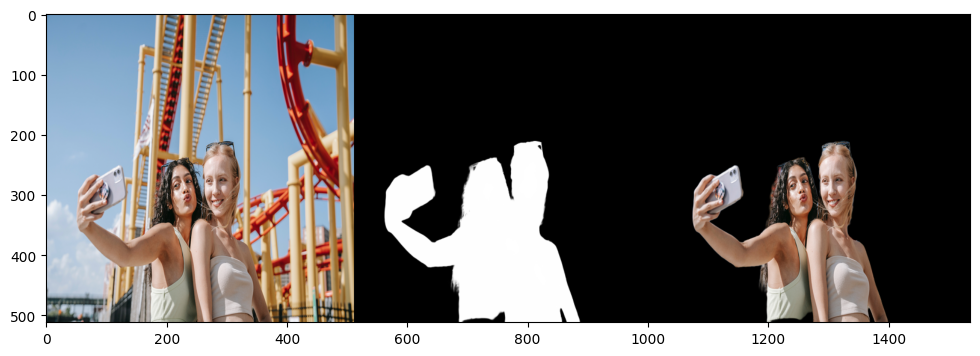

In [ ]:
from matplotlib import pyplot as plt

mask = cv2.cvtColor(res.squeeze(),cv2.COLOR_GRAY2RGB)
crop = inp * mask
comb = np.hstack([inp, mask, crop])

plt.figure(figsize = (20,4))
plt.imshow(comb)

In [ ]:

inp = Image.open('/content/pexels-julia-m-cameron.jpg')
inp = inp.resize((512, 512), Image.ANTIALIAS)
inp = np.asarray(inp)/255.0

# Preprocess images based on the original training/inference code
mean = [0.5, 0.5,  0.5 ]
std = [0.5,  0.5, 0.5]

img = (inp-mean)/std

img = img.transpose((2, 0, 1))
img = img[np.newaxis,...]

# Perform inference using the ONNX runtime
sess = rt.InferenceSession("/content/modnet_image.onnx")
input_name = sess.get_inputs()[0].name
pred_onnx = sess.run(None, {input_name: img.astype(np.float32)})[0]
res = pred_onnx

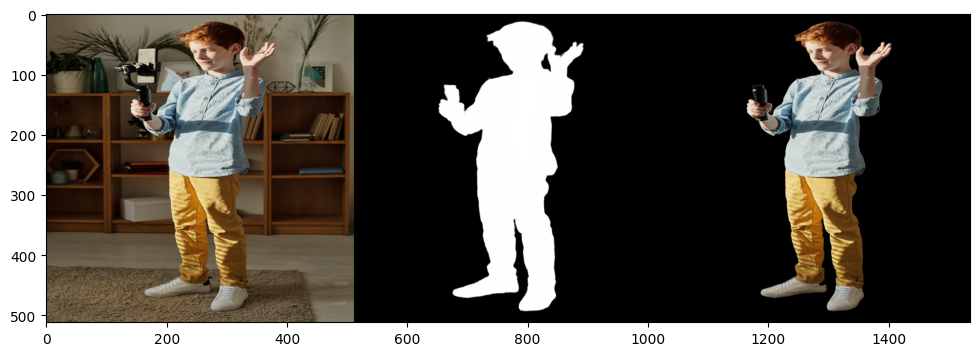

In [ ]:
mask = cv2.cvtColor(res.squeeze(),cv2.COLOR_GRAY2RGB)
crop = inp * mask
comb = np.hstack([inp, mask, crop])

plt.figure(figsize = (20,4))
plt.imshow(comb)

**Note:** In an ideal use case, you may need to resize the input image based on **aspect ratio** and rescale the output back to the original resolution.

**Video Segmentation**

Choose the pytorch model for **webcam portrait matting**.

In [ ]:
%cd /content/MODNet/
pretrained_ckpt = 'pretrained/modnet_webcam_portrait_matting.ckpt'

/content/MODNet


Convert the pytorch model to **onnx** format.

In [ ]:
import io
import PIL
import numpy as np

import torch
import torch.nn as nn
import torchvision.transforms as transforms

from src.models.modnet import MODNet

model = MODNet(backbone_pretrained=False)
model = nn.DataParallel(model).cuda()

state_dict = torch.load(pretrained_ckpt)
model.load_state_dict(state_dict)
model.eval()

dummy_input = torch.randn(1, 3, 512, 512).cuda()
torch.onnx.export(model.module, dummy_input, '/content/modnet_video.onnx', export_params = True, opset_version=12, do_constant_folding=True, verbose=True, keep_initializers_as_inputs=True)

**Optimize** the onnx model using onnx-simplifier.

In [ ]:
!python3 -m onnxsim /content/modnet_video.onnx /content/modnet_video_optim.onnx

Perform inference on video input, using **onnx-runtime**.

In [ ]:
import numpy as np
import cv2
import torch

# Input video file
video_input = "/content/pexel_video.mp4"
target_size =  (512,512)

# Video capturer and writer
vidcap = cv2.VideoCapture(video_input)
vidwrt = cv2.VideoWriter('result.mp4', cv2.VideoWriter_fourcc(*'MJPG'), 20, target_size)

# Load and resize the background image
bgd = cv2.imread('/content/manhattan.jpg')
bgd = cv2.resize(bgd, (512,512))

# Mean and std. deviation for normalization
mean = [0.5, 0.5, 0.5 ]
std = [0.5,  0.5, 0.5]

# Initialize onnx runtime session
sess = rt.InferenceSession("/content/modnet_video_optim.onnx")
input_name = sess.get_inputs()[0].name

# Initialize frame counter
frame_count = 0

while True:

    # Read input frames
    success, frame = vidcap.read()
    if not success:
           vidcap.release()
           vidwrt.release()
           break

    frame_count = frame_count + 1
    if frame_count%10 == 0:
      print("Processing frame: "+ str(frame_count))

    # Resize the input video frame
    frame = cv2.resize(frame, target_size, cv2.INTER_AREA)

    # Converet frame to RGB format
    img =  cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Normalize and add batch dimension
    img = img /255.0
    img = (img-mean)/std
    img = img.transpose((2, 0, 1))
    img = img[np.newaxis,...]


    # Perform inference using the ONNX runtime
    pred_onnx = sess.run(None, {input_name: img.astype(np.float32)})[0]
    alpha_matte=pred_onnx.squeeze() # 512x512


    # Alpha blending with background image
    mask = alpha_matte[..., np.newaxis]
    blend = (frame * mask) + (bgd * (1-mask))

    # Write the frames to a video file
    vidwrt.write(np.uint8(blend))

**Note:** In an ideal use case, you may need to resize the input frame based on **aspect ratio** and rescale the output back to the original resolution.

Display the **output** video on colaboratory

In [ ]:
from IPython.display import HTML
from base64 import b64encode

# Input and compresed video paths
save_path = "/content/MODNet/result.mp4"
compressed_path = "/content/MODNet/result_compressed.mp4"

# Compress the video using ffmpeg
os.system(f"ffmpeg -i {save_path} -vcodec libx264 {compressed_path}")

# Show the output video
mp4 = open(compressed_path,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

**Core ML Conversion**

Install latest **coremltools**.

In [ ]:
!pip install --upgrade coremltools

Choose the pytorch model for **portrait image matting**.

In [ ]:
%cd /content/MODNet/
pretrained_ckpt = 'pretrained/modnet_photographic_portrait_matting.ckpt'

Convert the pytorch model to **coreml**.

In [ ]:
import coremltools as ct
from src.models.modnet import MODNet


model = MODNet(backbone_pretrained=False)
model = nn.DataParallel(model).cuda()

state_dict = torch.load(pretrained_ckpt)
model.load_state_dict(state_dict)
model.eval()

# Get a pytorch model and save it as a *.pt file
pytorch_model = model.module
pytorch_model.eval()
example_input = torch.rand(1, 3, 512, 512).cuda()
traced_model = torch.jit.trace(pytorch_model, example_input)
traced_model.save("modnet_image.pt")

# Convert the saved PyTorch model to Core ML
mlmodel = ct.convert("modnet_image.pt",
                    inputs=[ct.TensorType(shape=(1, 3, 512, 512))])

# Save the coreml model
mlmodel.save("modnet_image.mlmodel")

Choose the pytorch model for **portrait video matting**.

In [ ]:
%cd /content/MODNet/
pretrained_ckpt = 'pretrained/modnet_webcam_portrait_matting.ckpt'

Convert the pytorch model to **coreml**.

In [ ]:
import coremltools as ct
from src.models.modnet import MODNet

model = MODNet(backbone_pretrained=False)
model = nn.DataParallel(model).cuda()

state_dict = torch.load(pretrained_ckpt)
model.load_state_dict(state_dict)
model.eval()

# Get a pytorch model and save it as a *.pt file
pytorch_model = model.module
pytorch_model.eval()
example_input = torch.rand(1, 3, 512, 512).cuda()
traced_model = torch.jit.trace(pytorch_model, example_input)
traced_model.save("modnet_video.pt")

# Convert the saved PyTorch model to Core ML
mlmodel = ct.convert("modnet_video.pt",
                    inputs=[ct.TensorType(shape=(1, 3, 512, 512))])

# Save the coreml model
mlmodel.save("modnet_video.mlmodel")

**ONNX2Tensorflow Conversion Issues**

Convert the onnx model to tensorflow using **onnx-tensorflow**.

In [ ]:
!git clone https://github.com/onnx/onnx-tensorflow.git
%cd onnx-tensorflow
!pip install -e .
!onnx-tf convert -i /content/modnet_image_optim.onnx -o /content/tfmodel

**Issues:-** RuntimeError - Resize coordinate_transformation_mode=pytorch_half_pixel is not supported in Tensorflow.


Convert the onnx model to keras using **onnx2keras**.

In [ ]:
!pip install onnx2keras

import onnx
from onnx2keras import onnx_to_keras

# Load ONNX model
onnx_model = onnx.load('/content/modnet_image_optim.onnx')
onnx.checker.check_model(onnx_model)
print('The model is checked!')

# Call the converter
k_model = onnx_to_keras(onnx_model, ['input.1'], change_ordering=True )

**Issues:**- KeyError- 'min' and/or KeyError: 'Resize'

The original model was trained in pytorch with **bilinear upsample and align corners=False**.

`F.interpolate(..., scale_factor=2, mode='bilinear', align_corners=False)`

It will create a resize layer with resize attribute **pytorch_halfpixel**. Currently, it looks like this behaviour is not supported by **tensorflow/keras**.



**References:-**


*   https://github.com/ZHKKKe/MODNet
*   https://github.com/onnx/onnx-tensorflow
*   https://github.com/nerox8664/onnx2keras
*   https://github.com/apple/coremltools/issues/1012
*   https://towardsdatascience.com/yolov3-pytorch-on-google-colab-c4a79eeecdea
*   https://github.com/daquexian/onnx-simplifier
*   https://coremltools.readme.io/docs/introductory-quickstart
*   https://github.com/onnx/onnx/blob/master/docs/PythonAPIOverview.md
*   https://github.com/microsoft/onnxruntime/blob/master/docs/python/tutorial.rst#step-3-load-and-run-the-model-using-onnx-runtime

